### <center> **Задача 1**

Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-07-14 по 2023-07-20. Ваша задача как аналитика – оценить эффективность этого мероприятия.

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from causalimpact import CausalImpact

import pandas as pd
import pandahouse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# параметры подключения
# наверное, их стоило удалить?..
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

### **1.** Предположим, что за время флэшмоба у нас возросла метрика CTR. Как будто бы логично, что метрика должна возрасти.

In [65]:
# для оптимизации заранее посчитаем стр для каждого пользователя
q = """
    SELECT
        toDate(time) AS date,
        ROUND(SUM(action='like') / SUM(action='view'), 4) AS ctr
    FROM simulator_20230720.feed_actions 
    GROUP BY date
    ORDER BY date
"""

# продолжим работу с пандасом, проверим данные
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,ctr
0,2023-06-03,0.2052
1,2023-06-04,0.2042
2,2023-06-05,0.1986
3,2023-06-06,0.2000
4,2023-06-07,0.1978


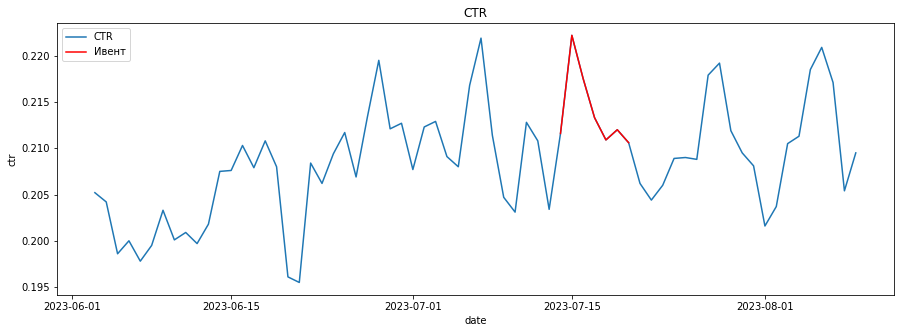

In [66]:
# для наглядности выделим дни ивента
event = df[(df['date'] <= '2023-07-20') & (df['date'] >= '2023-07-14')]

# строим график
fig = plt.figure(figsize=(15,5))
sns.lineplot(df, x='date', y='ctr', label='CTR').set(title='CTR')
sns.lineplot(event, x='date', y='ctr', color='red', label='Ивент');

**Вывод к графику:**  
Метрика CTR имеет очень пилообразный вид, но в начале имеет возрастающий тренд за первый месяц наблюдений. Далее метрика кажется стабильно не имеющей тренд, а влияние флэшмоба визуально не сказалось.
____

In [36]:
df = df['ctr']

df = CausalImpact(
    data=df,
    pre_period=[1,40],
    post_period=[41,47]
)

2023-08-09 09:05:43.526821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:05:43.559639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:05:44.252217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

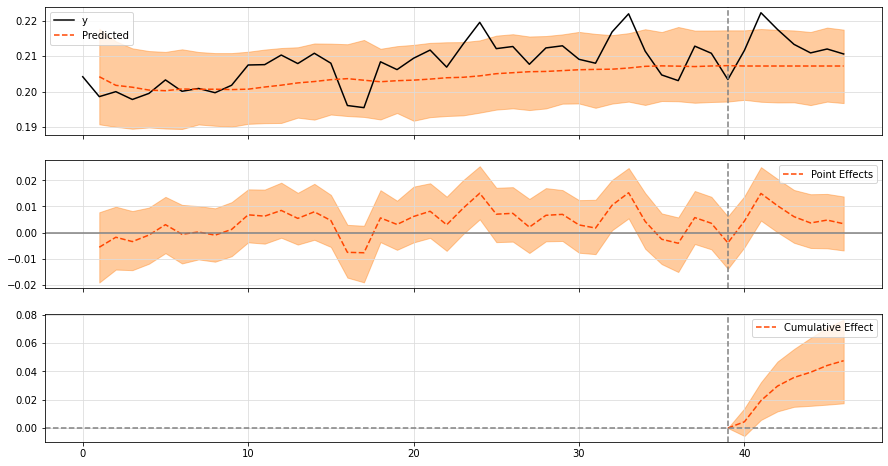

In [37]:
ctr_impact.plot(figsize=(15, 8))

In [38]:
print(ctr_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.02)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.28% (1.04%)      3.28% (1.04%)
95% CI                    [1.34%, 5.41%]     [1.34%, 5.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [12]:
print(ctr_impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

**Вывод:**  
Таким образом, модель Causal Impact считает, что эффект роста на 3.3% является статистически значимым и не связан со случайными событиями. Сложно сказать насколько такое изменение CTR можно считать важным, поскольку суть флэшмоба в привлечении новых, возвращении старых клиентов, а также увеличение активности лояльной аудитории. То есть, метрика CTR, по сути, и не должна была как-то значимо поменяться, поэтому давайте посмотрим не на соотношение, а на количество лайков и просмотров.

### **2.** Количество лайков и просмотров

In [40]:
# выгрузим данные
q = """
    SELECT
        toDate(time) AS date,
        SUM(action='like') AS likes,
        SUM(action='view') AS views
    FROM simulator_20230720.feed_actions
    GROUP BY date
    ORDER BY date
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,date,likes,views
0,2023-06-03,1560,7603
1,2023-06-04,12816,62770
2,2023-06-05,20958,105526
3,2023-06-06,23800,118996
4,2023-06-07,34504,174454


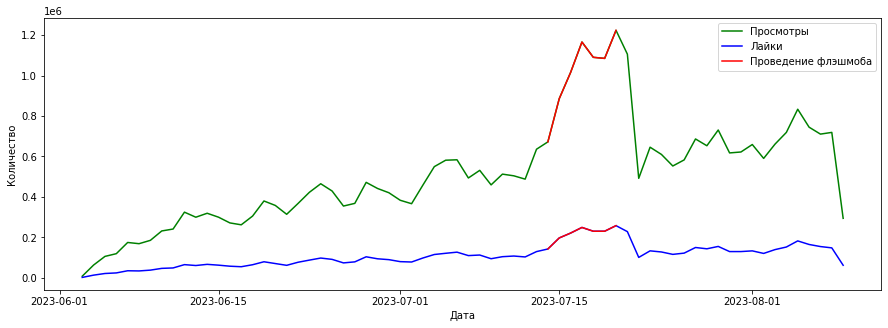

In [52]:
# Создаем фигуру и подграфики
fig, axes = plt.subplots(figsize=(15, 5))

# Строим графики и добавляем названия
sns.lineplot(data=df, x='date', y='views', color='green', label='Просмотры')
sns.lineplot(data=df, x='date', y='likes', color='blue', label='Лайки')
sns.lineplot(data=event, x='date', y='likes', color='red', label='Проведение флэшмоба')
sns.lineplot(data=event, x='date', y='views', color='red')

# Подписи к осям и отображение графиков
axes.set_xlabel('Дата')
axes.set_ylabel('Количество')
plt.show()

**Вывод по графику:**  
Как будто бы количество просмотров и лайков резко выросло после начала флэшмоба. Давайте проверим, мало ли что там кажется.
_________

In [53]:
# выделяем только лайки
likes = df['likes']

likes_impact = CausalImpact(
    data=likes,
    pre_period=[1,40],
    post_period=[41,47]
)

2023-08-09 09:18:15.151656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:18:15.179739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:18:15.749092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

2023-08-09 09:18:30.738579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-08-09 09:18:30.820400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

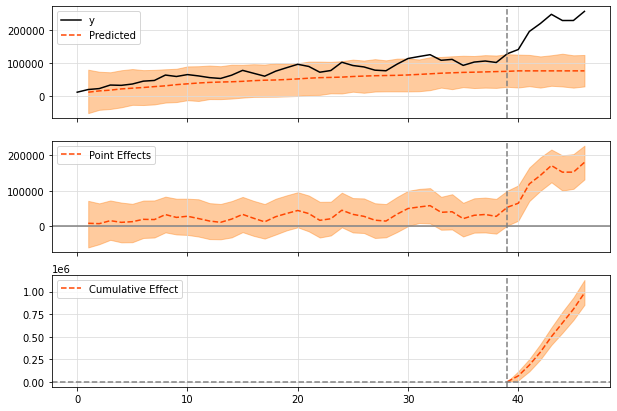

In [54]:
likes_impact.plot()

In [55]:
print(likes_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         77477.0 (9879.23)  542339.0 (69154.58)
95% CI                    [58121.91, 96847.77][406853.37, 677934.39]

Absolute effect (s.d.)    140613.14 (9879.23)984292.0 (69154.58)
95% CI                    [121242.37, 159968.23][848696.61, 1119777.63]

Relative effect (s.d.)    181.49% (12.75%)   181.49% (12.75%)
95% CI                    [156.49%, 206.47%] [156.49%, 206.47%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [56]:
# выделяем только просмотры
views = df['views']

views_impact = CausalImpact(
    data=views,
    pre_period=[1,40],
    post_period=[41,47]
)

2023-08-09 09:18:41.164928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:18:41.186726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:18:41.679397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

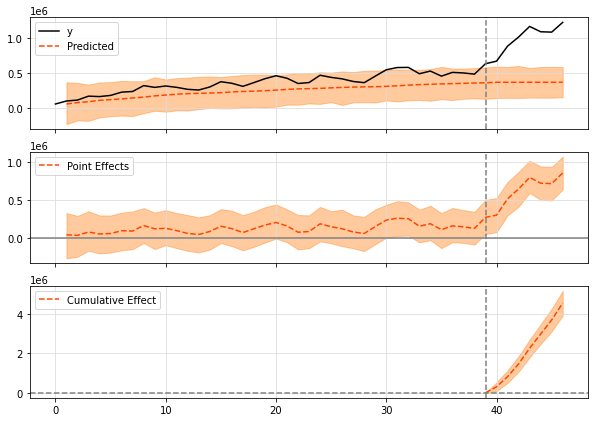

In [57]:
views_impact.plot()

In [58]:
print(views_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         371964.28 (45378.46)2603750.0 (317649.19)
95% CI                    [286430.23, 464310.56][2005011.67, 3250173.86]

Absolute effect (s.d.)    647983.0 (45378.46)4535881.0 (317649.19)
95% CI                    [555636.75, 733517.08][3889457.14, 5134619.33]

Relative effect (s.d.)    174.21% (12.2%)    174.21% (12.2%)
95% CI                    [149.38%, 197.2%]  [149.38%, 197.2%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


**Вывод:**  
Число просмотров выросло на 177%, а число лайков на 181%. Ну, тут без комментариев, влияние ивента очевидно.  
Правда вот после ивента мы видим, что количество лайков и просмотров вернулось к изначальным уровнем, и при этом оба параметра сохранили свои возрастающие тренды.

### **3.** DAU

In [67]:
# выгрузим данные
q = """
    SELECT
        toDate(time) AS date,
        COUNT(DISTINCT user_id) AS DAU
    FROM simulator_20230720.feed_actions 
    GROUP BY toDate(time)
    ORDER BY toDate(time)
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)

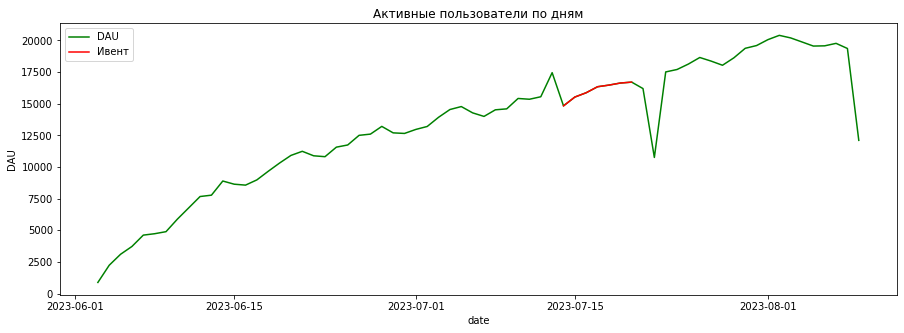

In [68]:
# для наглядности выделим дни ивента
event = df[(df['date'] <= '2023-07-20') & (df['date'] >= '2023-07-14')]

# строим график
fig = plt.figure(figsize=(15,5))
sns.lineplot(df, x='date', y='DAU', color='green', label='DAU').set(title='Активные пользователи по дням')
sns.lineplot(event, x='date', y='DAU', color='red', label='Ивент');

**Вывод по графику:**  
Количество активных пользователей имеет явно возрастающий тренд, однако влияение флэшмоба визуально кажется незначительным ...
_____

In [71]:
df = df['DAU']

dau_impact = CausalImpact(
    data=df,
    pre_period=[1, 40],
    post_period=[41, 47]
)

2023-08-09 09:23:28.627161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:23:28.654156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:23:29.195820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

2023-08-09 09:23:43.066238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-08-09 09:23:43.143610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

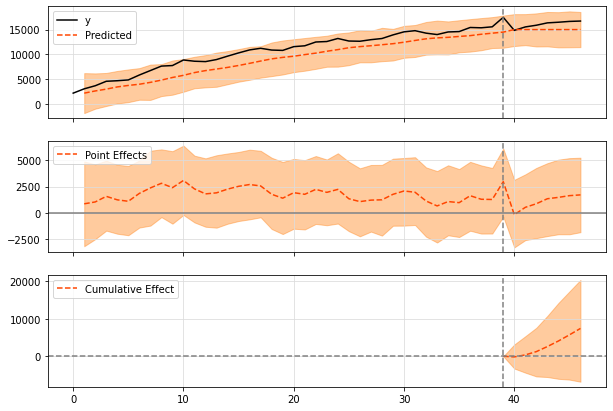

In [72]:
dau_impact.plot()

In [73]:
print(dau_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14992.19 (961.3)   104945.36 (6729.13)
95% CI                    [13188.64, 16956.89][92320.49, 118698.2]

Absolute effect (s.d.)    1060.52 (961.3)    7423.64 (6729.13)
95% CI                    [-904.17, 2864.07] [-6329.2, 20048.51]

Relative effect (s.d.)    7.07% (6.41%)      7.07% (6.41%)
95% CI                    [-6.03%, 19.1%]    [-6.03%, 19.1%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 85.11%

For more details run the command: print(impact.summary('report'))


**Вывод:**  
Метрика DAU выросла на чуть более чем 7% за время проведения флэшмоба, однако с вероятностью около 15% этот эффект вызван случайностью. Таким образом, считаем этот рост статистически не значимым.

### **4.** Новые пользователи

Раз количество активных юзеров у нас и так росло, давайте посмотри на количество новых пользователей.

In [77]:
# выгрузим данные
q = """
    SELECT
        first_act AS date,
        COUNT(user_id) AS new_users
    FROM (
        SELECT
            user_id,
            MIN(toDate(time)) AS first_act
        FROM simulator_20230720.feed_actions 
        GROUP BY user_id
    )
    GROUP BY date
    ORDER BY date
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)

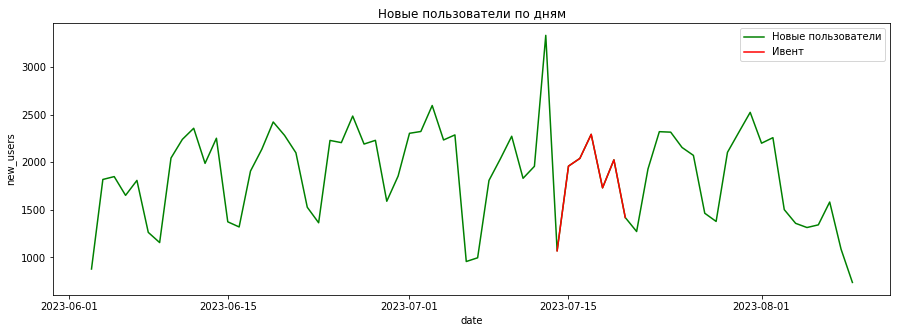

In [81]:
# для наглядности выделим дни ивента
event = df[(df['date'] <= '2023-07-20') & (df['date'] >= '2023-07-14')]

# построим график
fig = plt.figure(figsize=(15,5))
sns.lineplot(df, x='date', y='new_users', color='green', label='Новые пользователи').set(title='Новые пользователи по дням')
sns.lineplot(event, x='date', y='new_users', color='red', label='Ивент');

**Вывод по графику:**  
График имеет явную циклочность в 7 дней. В ЧТ-ПТ (это 8-9, 15-16, 22-23, 29 июня и 6-7, 14 июля) мы видим резкое падение количества новых пользователей нашего сервиса. А по понедельникам (5, 12, 19, 26 июня и 3, 10, 17 июля) мы видим всплески активности новых клиентов. Однако явным исключением из этого правила является 13 июля, когда был зафиксирован аномальный рост. Очевидно, что новые пользователи зарегестрировались как раз перед началом нашего мероприятия. Поэтому, по-хорошему, и этот день стоит включать в группу для анализа эффективности новой кампании.
______

In [82]:
df = df['new_users']

new_users_impact = CausalImpact(
    data=df,
    pre_period=[1, 39],
    post_period=[40, 47]
)

2023-08-09 09:33:04.807412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:33:04.830621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:33:05.386526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

2023-08-09 09:33:20.880268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-08-09 09:33:20.970255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

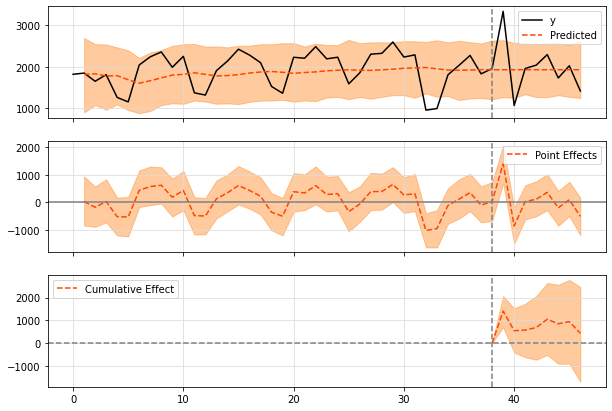

In [83]:
new_users_impact.plot()

In [84]:
print(new_users_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1983.62            15869.0
Prediction (s.d.)         1929.57 (125.77)   15436.53 (1006.18)
95% CI                    [1687.44, 2180.46] [13499.5, 17443.67]

Absolute effect (s.d.)    54.06 (125.77)     432.47 (1006.18)
95% CI                    [-196.83, 296.19]  [-1574.67, 2369.5]

Relative effect (s.d.)    2.8% (6.52%)       2.8% (6.52%)
95% CI                    [-10.2%, 15.35%]   [-10.2%, 15.35%]

Posterior tail-area probability p: 0.34
Posterior prob. of a causal effect: 66.23%

For more details run the command: print(impact.summary('report'))


**Вывод:**  
Мы получили примерно следующий результат: мы имеем небольшой положительный эффект в количестве новых пользователей, но этот эффект не является статистически значимым. Другими словами, количество новых пользователей итогово никак не изменилось за счет проведения флэшмоба. Результат не особо меняется и при изменении категории у дня с аномальным ростом пользователей.

### **5.** Количество постов

In [85]:
# выгрузим данные
q = """
    SELECT
        toDate(time) AS date,
        COUNT(DISTINCT post_id) AS posts
    FROM simulator_20230720.feed_actions
    GROUP BY toDate(time)
    ORDER BY toDate(time)
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)

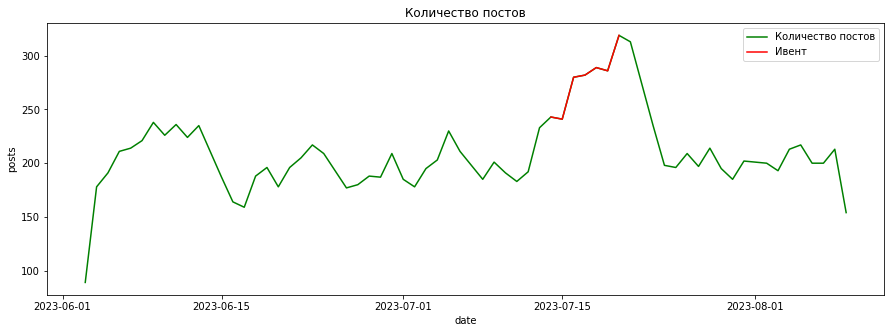

In [87]:
# для наглядности выделим дни ивента
event = df[(df['date'] <= '2023-07-20') & (df['date'] >= '2023-07-14')]

# строим график
fig = plt.figure(figsize=(15,5))
sns.lineplot(df, x='date', y='posts', color='green', label='Количество постов').set(title='Количество постов')
sns.lineplot(event, x='date', y='posts', color='red', label='Ивент');

**Вывод к графику:**  
Перед началом флэшмоба появился резкий рост количества постов, который и продолжился в течение его проведения.
_______

In [88]:
post_df = df['posts']

post_impact = CausalImpact(
    data=post_df,
    pre_period=[1, 40],
    post_period=[41, 47]
)

2023-08-09 09:36:34.374101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:36:34.401459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:36:34.926839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 09:

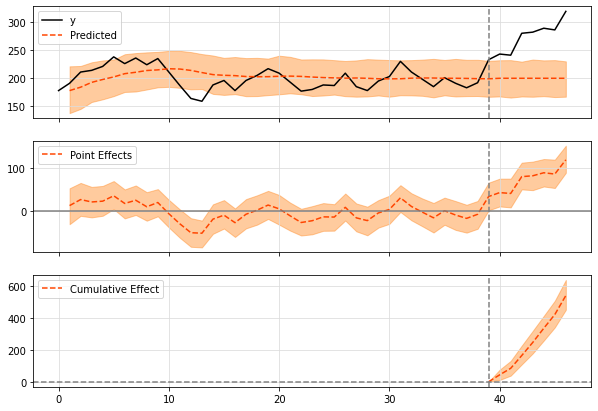

In [89]:
post_impact.plot()

In [90]:
print(post_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.14             1940.0
Prediction (s.d.)         199.91 (6.56)      1399.37 (45.95)
95% CI                    [187.48, 213.21]   [1312.36, 1492.48]

Absolute effect (s.d.)    77.23 (6.56)       540.63 (45.95)
95% CI                    [63.93, 89.66]     [447.52, 627.64]

Relative effect (s.d.)    38.63% (3.28%)     38.63% (3.28%)
95% CI                    [31.98%, 44.85%]   [31.98%, 44.85%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


**Вывод:**  
Количество постов в период проведения ивента выросло почти на 40% относительно ожиданий, отчет считает эффект однозначно статистически значимым. Однако сразу после количество постов вернулось на примерно тот же стагнирующий уровень.

### **6.** Количество лайков и просмотров на одного пользователя

In [104]:
# выгрузим данные
q = """
    SELECT
        date,
        ROUND(likes / unique_users, 3) AS likes_per_user,
        ROUND(views / unique_users, 3) AS views_per_user
    FROM(
        SELECT
            toDate(time) AS date,
            SUM(action='like') AS likes,
            SUM(action='view') AS views,
            COUNT(DISTINCT user_id) AS unique_users
        FROM simulator_20230720.feed_actions 
        GROUP BY date
    ) AS t
    ORDER BY date
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)

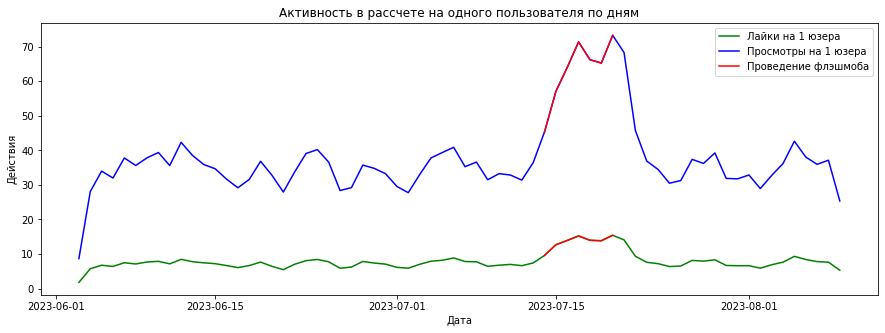

In [111]:
# для наглядности выделим дни ивента
event = df[(df['date'] <= '2023-07-20') & (df['date'] >= '2023-07-14')]

# Создаем фигуру и подграфики
fig, axes = plt.subplots(figsize=(15, 5))

# Строим графики и добавляем названия
sns.lineplot(data=df, x='date', y='likes_per_user', color='green', label='Лайки на 1 юзера')
sns.lineplot(data=df, x='date', y='views_per_user', color='blue', label='Просмотры на 1 юзера')
sns.lineplot(data=event, x='date', y='likes_per_user', color='red', label='Проведение флэшмоба')
sns.lineplot(data=event, x='date', y='views_per_user', color='red').set_title('Активность в рассчете на одного пользователя по дням')

# Подписи к осям и отображение графиков
axes.set_xlabel('Дата')
axes.set_ylabel('Действия')
plt.show()

**Вывод к графику:**  
И вновь в дни флэшмоба и за несколько дней до мы видим активной рост обеих метрик. Оценим насколько он значим.
________

In [119]:
# выделим нужный фрагмент
lpu_df = df['likes_per_user']

# проведем анализ
lpu_df_impact = CausalImpact(
    data=lpu_df,
    pre_period=[1, 40],
    post_period=[41, 47]
)

2023-08-09 10:23:36.020315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:23:36.045375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:23:36.598860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:

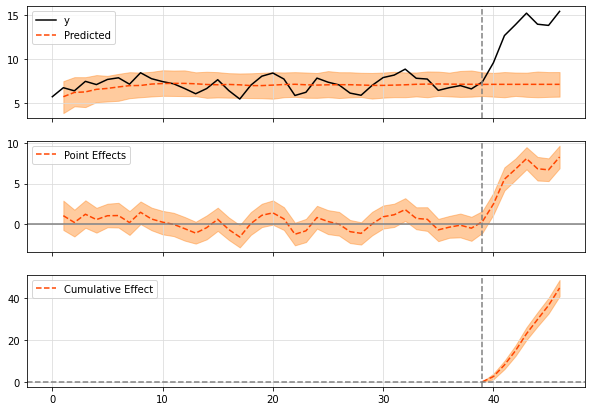

In [120]:
# построим графики предсказаний
lpu_df_impact.plot()

In [121]:
# выведем итог
print(lpu_df_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    13.52              94.65
Prediction (s.d.)         7.13 (0.28)        49.93 (1.97)
95% CI                    [6.58, 7.68]       [46.03, 53.74]

Absolute effect (s.d.)    6.39 (0.28)        44.72 (1.97)
95% CI                    [5.84, 6.95]       [40.91, 48.62]

Relative effect (s.d.)    89.56% (3.94%)     89.56% (3.94%)
95% CI                    [81.93%, 97.37%]   [81.93%, 97.37%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [122]:
# выделим только нужные нам данные
vpu_df = df['views_per_user']

# проведем анализ
lpu_df_impact = CausalImpact(
    data=vpu_df,
    pre_period=[1, 40],
    post_period=[41, 47]
)

2023-08-09 10:24:05.747641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:24:05.785515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:24:06.448042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-08-09 10:

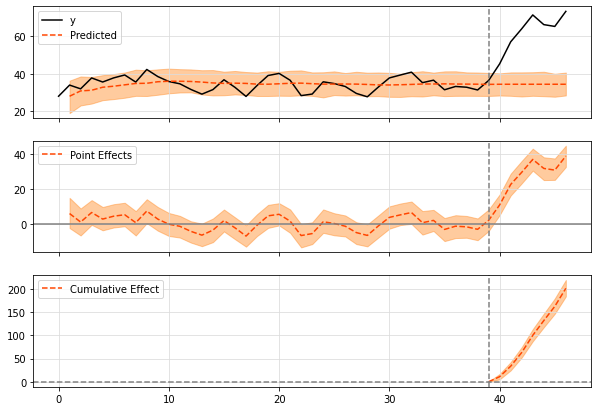

In [124]:
# построим график предсказаний
lpu_df_impact.plot()

In [123]:
# выведем итог
print(lpu_df_impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    63.21              442.5
Prediction (s.d.)         34.42 (1.19)       240.97 (8.36)
95% CI                    [32.12, 36.8]      [224.86, 257.61]

Absolute effect (s.d.)    28.79 (1.19)       201.53 (8.36)
95% CI                    [26.41, 31.09]     [184.89, 217.64]

Relative effect (s.d.)    83.63% (3.47%)     83.63% (3.47%)
95% CI                    [76.73%, 90.32%]   [76.73%, 90.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


**Вывод:**  
Обе метрики явно выросли за счет проведения ивента на более чем 80%, что, конечно же, является статистически значимой величиной. Однако, как мы уже замечали ранее, после окончания ивента обе метрики вернулись на свой обычный, дофлэшмобовский уровень с сохранением еле заметного положительного тренда.

**Дополнительно посмотрим на retention rate у пользователей, которые пришли 13 июля. Для наглядности возьмем по две соседние даты.**  

In [125]:
# выгрузим данные
q = """
    SELECT
        toString(first_act) AS start_day,
        date,
        users / max_users AS retention_rate
    FROM(
        SELECT
           first_act,
           date,
           COUNT(user_id) AS users,
           MAX(users) OVER(PARTITION BY first_act) AS max_users
        FROM (
            SELECT
                user_id,
                MIN(toDate(time)) AS first_act
            FROM simulator_20230720.feed_actions
            GROUP BY user_id
            HAVING MIN(toDate(time)) BETWEEN '2023-07-11' AND '2023-07-15'
        ) AS a
        JOIN (
            SELECT DISTINCT user_id, toDate(time) AS date
            FROM simulator_20230720.feed_actions
        ) AS b USING(user_id)
        GROUP BY first_act, date
    )
    ORDER BY first_act, date
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)

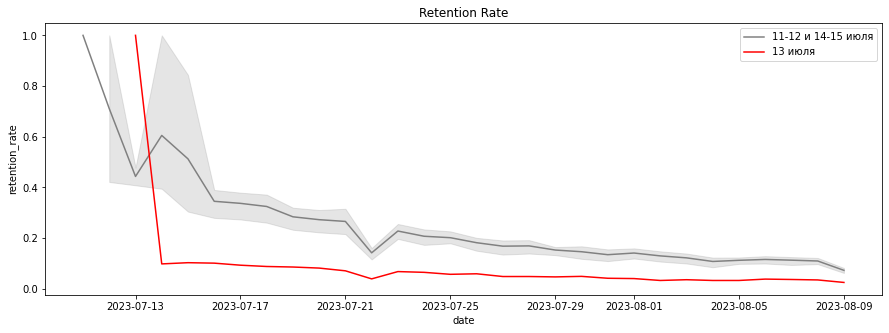

In [128]:
event = df[df['start_day'] == '2023-07-13']
not_event = df[df['start_day'] != '2023-07-13']


fig = plt.figure(figsize=(15,5))
sns.lineplot(not_event, x='date', y='retention_rate',  color='gray', label='11-12 и 14-15 июля').set(title='Retention Rate')
sns.lineplot(event, x='date', y='retention_rate', color='red', label='13 июля');

**Вывод:**  
13 июля был день аномального количества притока новых клиентов. Однако удержать этих клиентов не получается, поскольку метрика RT одна из самых низких, по сравнению с другими стартовыми датами. Для наглядности было выведено только по две соседней даты, но с добавлением дополнительных дат и изменением типа визуализации, например, на тепловую карту результат не меняется. Клиентов ивентом привлекли, но удержать не смогли.

### <center> **Общий вывод** 

К сожалению, у нас нет данных о доходах и расходах (а предположить их неверно = исказить результат), а также не знаем цели данного ивента (заработать деньги / привлечь новых клиентов / проверить влияение подобных мероприятий и тд), поэтому мы не можем сделать глобальный вывод о его эффективности. Попробуем взглянуть на результат с разных сторон.

**1.** Ивент в каком-то смысле смог повысить активность пользователей, так как во время ивента повысился целый ряд ключевых метрик, таких как количество лайков и просмотров, пусть незначительно, но все же вырос CTR. В то же время на количество активных пользователей влияение не было.

**2.** Привлечь новых клиентов нам не удалось. То есть да, мы действительно увидели всплеск первых действий от новых клиентов за день до мероприятия. Но на их количество не повлиял сам ивент. Другими словами, эти люди, скорее всего, и так бы зарегистрировались в нашем приложении. Возможно, у нас была слабая рекламная кампания по распространению или эффективности.

**3.** Самая главная проблема, на мой взгляд, это аномально низкий уровень удержания. Из клиентов, зарегестрированных 13 июля, т.е. за день до регистрации, на следующий день вернулись в приложение около 10%, в то время как обычно этот показатель на уровне 40-45%. А через месяц уровень удержания значительно ниже, чем в других кагортах. 